In [109]:
# # for colab
# from google.colab import drive
# drive.mount('/content/drive')
# % cd drive/MyDrive/Plankton-Patrol/notebooks/plankton_patrol_models

# Introduction

This notebook is for practicing XGBoost and initial analyzation of Water Quality dataset from the [Chesapeake Bay Project DataHub](https://datahub.chesapeakebay.net/WaterQuality). 

In [155]:
import shap
import xgboost as xgb
from sklearn.model_selection import KFold, train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
import pandas as pd
import numpy as np

In [156]:
water = pd.read_csv('../../data/plank_ChesapeakeWaterQuality_clean.csv')

/var/folders/rl/kqt6tbv90l9_pwc4927vdb340000gn/T/ipykernel_46653/4047237986.py:1: DtypeWarning: Columns (28) have mixed types. Specify dtype option on import or set low_memory=False.
  water = pd.read_csv('../../data/plank_ChesapeakeWaterQuality_clean.csv')


# Basic set up

In [157]:
water.shape

(39490, 66)

In [158]:
water['EventId'].nunique()

20140

Let's remove columns missing more than 90% of the values.

In [159]:
threshold = 0.9

missing_percentage = water.isnull().mean()

columns_to_keep = missing_percentage[missing_percentage <= threshold].index

# Create a new DataFrame with only the columns to keep
water_clean = water[columns_to_keep]

print('Remaining columns:', water_clean.columns)


Remaining columns: Index(['CBSeg2003', 'EventId', 'Cruise', 'Program', 'Project', 'Agency',
       'Source', 'Station', 'SampleDate', 'SampleTime', 'TotalDepth',
       'UpperPycnocline', 'LowerPycnocline', 'Depth', 'Layer', 'SampleType',
       'SampleReplicateType', 'Qualifier', 'Method', 'Lab', 'Problem',
       'Details', 'Latitude', 'Longitude', 'TierLevel', 'AirTemp', 'WindSpeed',
       'WindDirection', 'TideStage', 'WaveHeight', 'CloudCover', 'CHLA', 'DIN',
       'DO', 'DON', 'DOP', 'FSS', 'KD', 'NH4F', 'NO23F', 'NO2F', 'NO3F', 'PC',
       'PH', 'PHEO', 'PN', 'PO4F', 'PP', 'SALINITY', 'SECCHI', 'SIF',
       'SIGMA_T', 'SPCOND', 'TDN', 'TDP', 'TN', 'TON', 'TP', 'TSS', 'VSS',
       'WTEMP'],
      dtype='object')


In [160]:
water_clean.shape

(39490, 61)

## XGBoost

Since this dataset did not include any chlrophyl data, we will pick some other parameters to model. How about `PCT_PI_BIO` - Percent Pollution Indicative Species.

### Preprocess

Converting `SampleDateTime` to an integer. First converting back to datetime.

In [161]:
water_clean = water_clean.copy()

water_clean['SampleDateTime'] = pd.to_datetime(water_clean['SampleDate'] + ' ' + water_clean['SampleTime'], format='%m/%d/%Y %H:%M:%S')

water_clean['IntDateTime'] = water_clean['SampleDateTime'].astype('int64')//10**9

water_clean['floatDateTime'] = water_clean['IntDateTime'].astype('float64')


water_clean = water_clean.drop(columns=['SampleDateTime','IntDateTime'])

Modifying Pushkar's function for converting datatypes, we make sure every column is either a float or category.

In [162]:
numerical_features = water_clean.select_dtypes(include='float').columns
categorical_features = list(set(water_clean.columns) - set(numerical_features))

In [163]:
def convert_dtypes(df):
    for col in df.columns:
        df[col] = df[col].replace("nan", np.nan)
        # print(df[col][564463])
        print(f"converting column {col}",end="\t")
        print(df[col].dtype)

        if col not in (numerical_features):
            df[col] = pd.Categorical(df[col])
            print("Categorical")
        elif col in numerical_features:
            # Try converting to numeric (float)
            df[col] = pd.to_numeric(df[col], errors="coerce")

            # Handle missing values
            df[col].fillna(df[col].median(), inplace=True)
            print("Numeric")
        else:
            print(f"{col}: string")
            df[col] = df[col].astype(str)
            print("string")
        print(df[col].dtype)
    return df

In [ ]:
water_clean = convert_dtypes(water_clean)

Let's check

In [165]:
water_clean.dtypes

CBSeg2003    category
EventId       float64
Cruise       category
Program      category
Project      category
               ...   
TON           float64
TP            float64
TSS           float64
VSS           float64
WTEMP         float64
Length: 61, dtype: object

### Define and train regression


In [166]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

def split_data(water_clean):
  # Split features and target
  X = water_clean.drop('CHLA', axis=1)
  y = water_clean['CHLA']

  for col in X.select_dtypes(include=['category']).columns:
    X[col] = X[col].cat.codes

  print(X.shape, y.shape)
   
  # Split into training and test sets
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
  return X_train, X_test, y_train, y_test

# Split the data
X_train, X_test, y_train, y_test = split_data(water_clean)

(39490, 60) (39490,)


In [167]:
params = dict()
params["tree_method"] = "hist"

In [168]:
model = xgb.XGBRegressor(enable_categorical=True)
model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=True, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [169]:
predictions = model.predict(X_test)
mse = mean_squared_error(y_test, predictions)
print("MSE: %f" % (mse))

MSE: 22.392280


## Estimate the Shapley values

Copied from Pushkar

In [170]:


explainer = shap.Explainer(model=model, masker=X_train)
explainer.__class__

# explainer = shap.TreeExplainer(model, data=cp.asarray(X_train_cp))
# shap_values = explainer.shap_values(cp.asarray(X_test_cp))

# Convert Shapley values back to NumPy arrays for compatibility
# shap_values = cp.asnumpy(shap_values)

shap.explainers._tree.TreeExplainer

In [171]:
shap_values = explainer(X_test)

 99%|===================| 7819/7898 [00:34<00:00]        

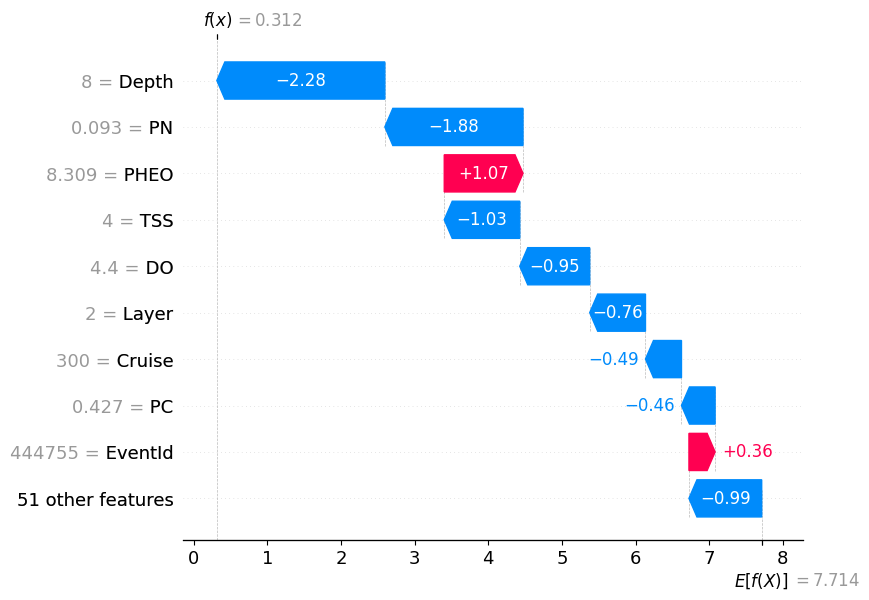

In [172]:
shap.plots.waterfall(shap_values[0])

In [173]:
shap.initjs()

shap.plots.force(shap_values[0])

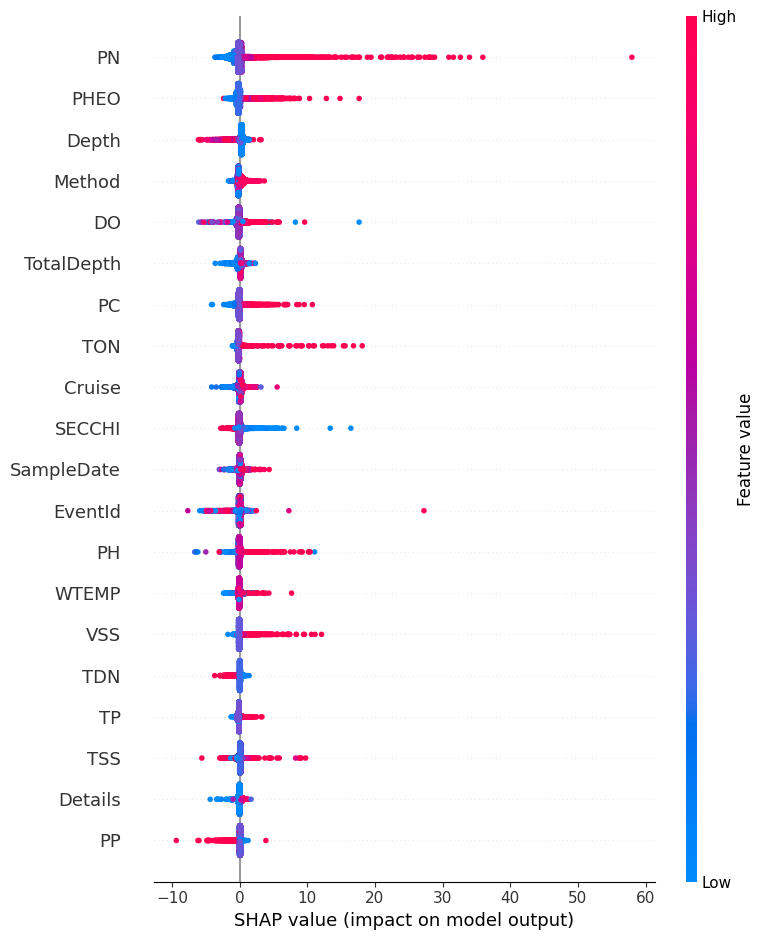

In [174]:
shap.summary_plot(shap_values,X_test)

# A bit more cleaning

Let's drop som columns related to who collected the data: `Program`, `Project`, `Agency`, `Source`
And `TotalDepth` is the station, not the sample.

In [175]:
water_clean = water_clean.drop(columns=['Program','Project','Agency','Source','TotalDepth','TierLevel'])

In [176]:
water_clean = convert_dtypes(water_clean)

converting column CBSeg2003	category
Categorical
category
converting column EventId	float64
Numeric
float64
converting column Cruise	category
Categorical
category
converting column Station	category
Categorical
category
converting column SampleDate	category
Categorical
category
converting column SampleTime	category
Categorical
category
converting column UpperPycnocline	float64
Numeric
float64
converting column LowerPycnocline	float64
Numeric
float64
converting column Depth	float64
Numeric
float64
converting column Layer	category
Categorical
category
converting column SampleType	category
Categorical
category
converting column SampleReplicateType	category
Categorical
category
converting column Qualifier	category
Categorical
category
converting column Method	category
Categorical
category
converting column Lab	category
Categorical
category
converting column Problem	category
Categorical
category
converting column Details	category
Categorical
category
converting column Latitude	float64
Numeri

/var/folders/rl/kqt6tbv90l9_pwc4927vdb340000gn/T/ipykernel_46653/514992669.py:16: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna(df[col].median(), inplace=True)
/var/folders/rl/kqt6tbv90l9_pwc4927vdb340000gn/T/ipykernel_46653/514992669.py:16: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always

### Define and train regression


In [177]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

def split_data(water_clean):
  # Split features and target
  X = water_clean.drop('CHLA', axis=1)
  y = water_clean['CHLA']

  for col in X.select_dtypes(include=['category']).columns:
    X[col] = X[col].cat.codes

  print(X.shape, y.shape)
   
  # Split into training and test sets
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
  return X_train, X_test, y_train, y_test

# Split the data
X_train, X_test, y_train, y_test = split_data(water_clean)

(39490, 54) (39490,)


In [178]:
params = dict()
params["tree_method"] = "hist"

In [179]:
model = xgb.XGBRegressor(enable_categorical=True)
model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=True, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [180]:
predictions = model.predict(X_test)
mse = mean_squared_error(y_test, predictions)
print("MSE: %f" % (mse))

MSE: 21.388198


## Estimate the Shapley values

Copied from Pushkar

In [181]:


explainer = shap.Explainer(model=model, masker=X_train)
explainer.__class__

# explainer = shap.TreeExplainer(model, data=cp.asarray(X_train_cp))
# shap_values = explainer.shap_values(cp.asarray(X_test_cp))

# Convert Shapley values back to NumPy arrays for compatibility
# shap_values = cp.asnumpy(shap_values)

shap.explainers._tree.TreeExplainer

In [182]:
shap_values = explainer(X_test)

 99%|===================| 7844/7898 [00:40<00:00]        

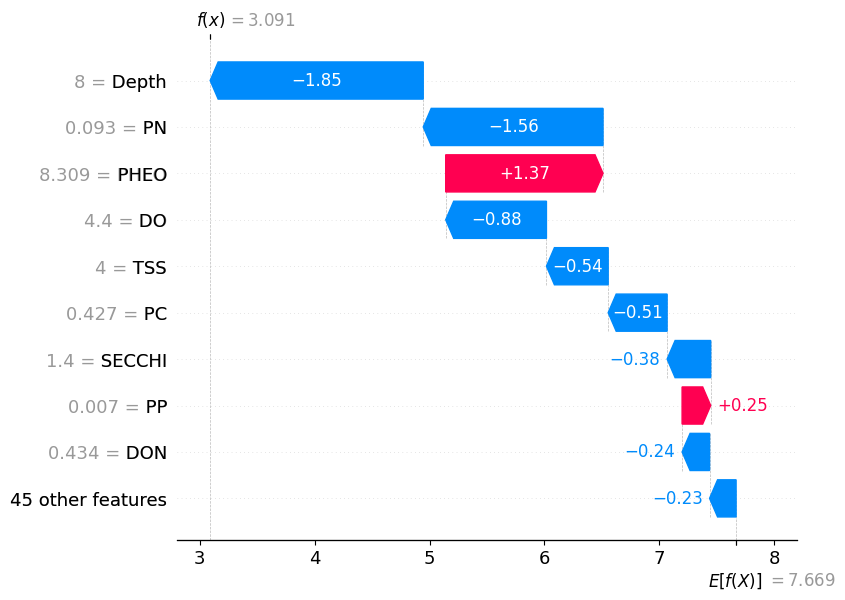

In [183]:
shap.plots.waterfall(shap_values[0])

In [184]:
shap.plots.force(shap_values[0])

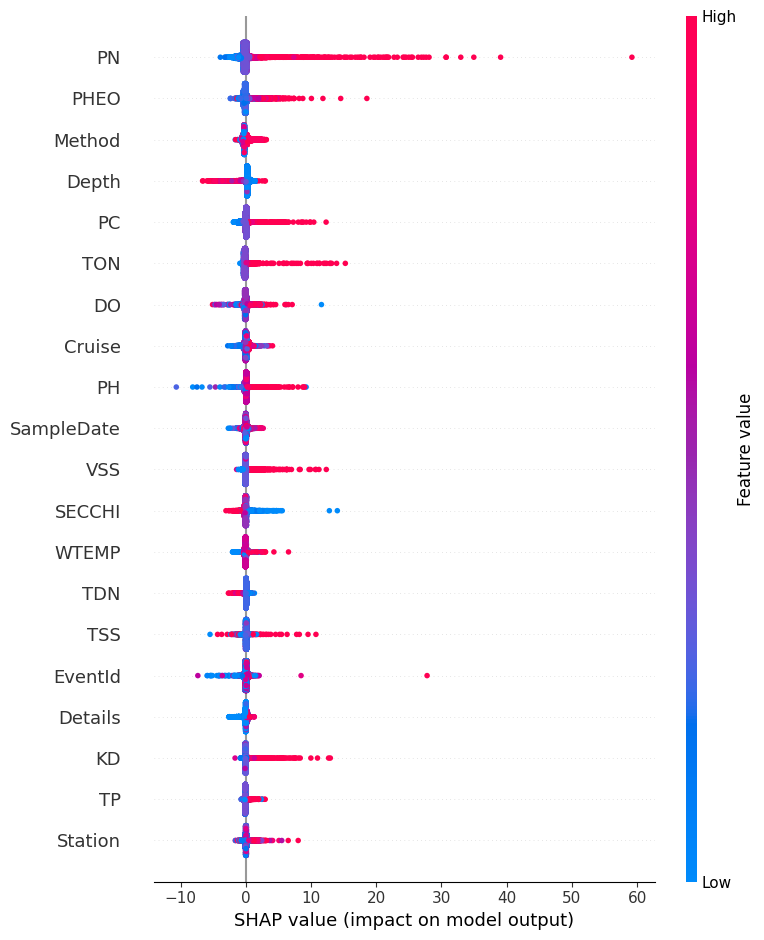

In [185]:
shap.summary_plot(shap_values,X_test)